Processing Hospital1...
Error loading data for Hospital1_patients: [Errno 2] No such file or directory: 'Hospital1.txt'
Processing Hospital2...
Error loading data for Hospital2_patients: [Errno 2] No such file or directory: 'Hospital2.txt'

Hospital1 Data Analysis:
----------------------------------------
Number of Patients Readmitted: 38
Average Staff Satisfaction: 3.51
Average Cleanliness Satisfaction: 3.61
Average Food Satisfaction: 3.51
Average Comfort Satisfaction: 3.72
Average Communication Satisfaction: 3.70

Logistic Regression Results:
              precision    recall  f1-score   support

           0       0.61      0.56      0.58        36
           1       0.61      0.66      0.63        38

    accuracy                           0.61        74
   macro avg       0.61      0.61      0.61        74
weighted avg       0.61      0.61      0.61        74


Hospital2 Data Analysis:
----------------------------------------
Number of Patients Readmitted: 29
Average Staff Satisfa

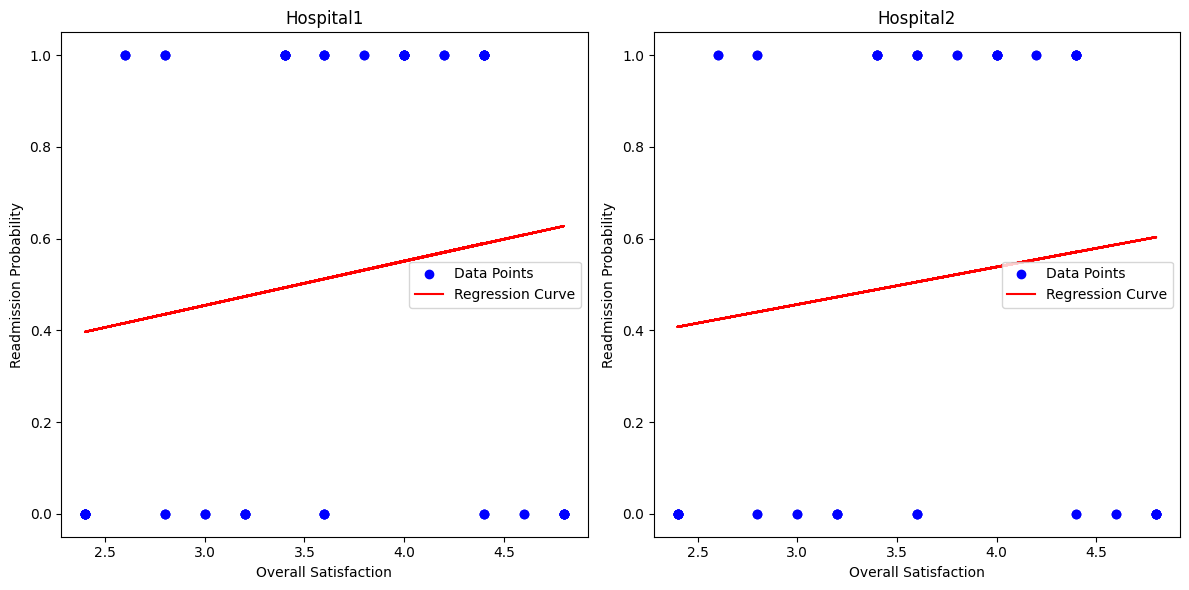


Hospital Comparison:
--------------------
Readmission Rate (%):
Hospital1: 51.35%
Hospital2: 50.88%

Average Satisfaction Scores:
Hospital1: 3.61
Hospital2: 3.64

Logistic Regression Accuracy:
Hospital1: 0.61
Hospital2: 0.61


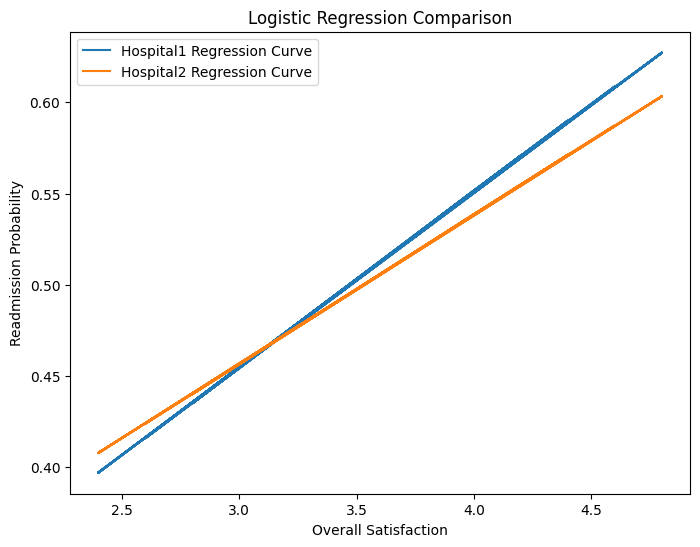


Based on the analysis, Hospital2 performs better in terms of overall satisfaction.


In [ ]:
import sqlite3
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import pathlib

conn = sqlite3.connect("hospital_data.db")
cursor = conn.cursor()

def create_table(hospital_name):
    table_name = f"{hospital_name}_patients"
    cursor.execute(f"""
    CREATE TABLE IF NOT EXISTS {table_name} (
        PatientID INTEGER PRIMARY KEY,
        Readmission INTEGER,
        StaffSatisfaction INTEGER,
        CleanlinessSatisfaction INTEGER,
        FoodSatisfaction INTEGER,
        ComfortSatisfaction INTEGER,
        CommunicationSatisfaction INTEGER
    )
    """)
    conn.commit()
    return table_name

def load_data(file_path, table_name):
    try:
        with open(file_path, "r") as file:
            lines = file.readlines()
            for line in lines[1:]:  
                data = tuple(map(int, line.strip().split(",")))
                cursor.execute(f"""
                INSERT INTO {table_name} (PatientID, Readmission, StaffSatisfaction, 
                                           CleanlinessSatisfaction, FoodSatisfaction, 
                                           ComfortSatisfaction, CommunicationSatisfaction)
                VALUES (?, ?, ?, ?, ?, ?, ?)
                """, data)
        conn.commit()
    except Exception as e:
        print(f"Error loading data for {table_name}: {e}")

def analyze_hospital(table_name):
    cursor.execute(f"SELECT COUNT(*) FROM {table_name} WHERE Readmission = 1")
    readmitted_count = cursor.fetchone()[0]
    
    satisfaction_columns = [
        "StaffSatisfaction", "CleanlinessSatisfaction",
        "FoodSatisfaction", "ComfortSatisfaction", "CommunicationSatisfaction"
    ]
    averages = {}
    for category in satisfaction_columns:
        cursor.execute(f"SELECT AVG({category}) FROM {table_name}")
        averages[category] = cursor.fetchone()[0]
    
    query = f"""
    SELECT Readmission, 
           (StaffSatisfaction + CleanlinessSatisfaction + FoodSatisfaction + 
            ComfortSatisfaction + CommunicationSatisfaction) / 5.0 AS OverallSatisfaction
    FROM {table_name}
    """
    df = pd.read_sql_query(query, conn)
    X = df[['OverallSatisfaction']].values
    y = df['Readmission'].values
    model = LogisticRegression()
    model.fit(X, y)
    probabilities = model.predict_proba(X)[:, 1]
    y_pred = model.predict(X)
    
    return {
        "readmitted_count": readmitted_count,
        "averages": averages,
        "model": model,
        "X": X,
        "y": y,
        "probabilities": probabilities,
        "classification_report": classification_report(y, y_pred, output_dict=True)
    }

hospital_files = {
    "Hospital1": pathlib.Path("Hospital1.txt"),
    "Hospital2": pathlib.Path("Hospital2.txt")
}

results = {}
for hospital_name, file_path in hospital_files.items():
    print(f"Processing {hospital_name}...")
    table_name = create_table(hospital_name)
    load_data(file_path, table_name)
    results[hospital_name] = analyze_hospital(table_name)

for hospital_name, result in results.items():
    print(f"\n{hospital_name} Data Analysis:\n{'-'*40}")
    print(f"Number of Patients Readmitted: {result['readmitted_count']}")
    for category, avg in result['averages'].items():
        print(f"Average {category.replace('Satisfaction', '')} Satisfaction: {avg:.2f}")
    print("\nLogistic Regression Results:")
    print(classification_report(result['y'], result['model'].predict(result['X'])))

plt.figure(figsize=(12, 6))
for i, (hospital_name, result) in enumerate(results.items(), start=1):
    plt.subplot(1, 2, i)
    plt.scatter(result['X'], result['y'], c='blue', label='Data Points')
    plt.plot(result['X'], result['probabilities'], color='red', label='Regression Curve')
    plt.xlabel('Overall Satisfaction')
    plt.ylabel('Readmission Probability')
    plt.title(hospital_name)
    plt.legend()
plt.tight_layout()
plt.show()

comparison = {
    "Readmission Rate": {
        "Hospital1": results["Hospital1"]["readmitted_count"] / len(results["Hospital1"]["y"]) * 100,
        "Hospital2": results["Hospital2"]["readmitted_count"] / len(results["Hospital2"]["y"]) * 100
    },
    "Average Satisfaction": {
        "Hospital1": sum(results["Hospital1"]["averages"].values()) / len(results["Hospital1"]["averages"]),
        "Hospital2": sum(results["Hospital2"]["averages"].values()) / len(results["Hospital2"]["averages"])
    },
    "Correlation Strength": {
        "Hospital1": results["Hospital1"]["classification_report"]["accuracy"],
        "Hospital2": results["Hospital2"]["classification_report"]["accuracy"]
    }
}

print("\nHospital Comparison:\n" + "-"*20)
print(f"Readmission Rate (%):")
for hospital, rate in comparison["Readmission Rate"].items():
    print(f"{hospital}: {rate:.2f}%")
print("\nAverage Satisfaction Scores:")
for hospital, avg in comparison["Average Satisfaction"].items():
    print(f"{hospital}: {avg:.2f}")
print("\nLogistic Regression Accuracy:")
for hospital, accuracy in comparison["Correlation Strength"].items():
    print(f"{hospital}: {accuracy:.2f}")

plt.figure(figsize=(8, 6))
for hospital_name, result in results.items():
    plt.plot(result['X'], result['probabilities'], label=f"{hospital_name} Regression Curve")
plt.xlabel('Overall Satisfaction')
plt.ylabel('Readmission Probability')
plt.legend()
plt.title('Logistic Regression Comparison')
plt.show()

better_hospital = max(comparison["Average Satisfaction"], key=comparison["Average Satisfaction"].get)
print(f"\nBased on the comparison between Hospital 1 and Hospital 2, {better_hospital} performs better in terms of overall satisfaction.")

conn.close()
